Preprocessing

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer


df = pd.read_csv('../data/raw/healthcare-dataset-stroke-data.csv')
df = df.drop(columns=['id'])
imputer = SimpleImputer(strategy='mean')
df['bmi'] = imputer.fit_transform(df[['bmi']])
df['hypertension'] = df['hypertension'].map({0: 'No', 1: 'Yes'})
df['heart_disease'] = df['heart_disease'].map({0: 'No', 1: 'Yes'})
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 
                                 'Residence_type', 'smoking_status', 'hypertension', 
                                 'heart_disease'], drop_first=True)
print(df.dtypes)

age                               float64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
gender_Male                          bool
gender_Other                         bool
ever_married_Yes                     bool
work_type_Never_worked               bool
work_type_Private                    bool
work_type_Self-employed              bool
work_type_children                   bool
Residence_type_Urban                 bool
smoking_status_formerly smoked       bool
smoking_status_never smoked          bool
smoking_status_smokes                bool
hypertension_Yes                     bool
heart_disease_Yes                    bool
dtype: object


In [2]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

F1

In [3]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, 10, 20, 50],
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")
# predit all strokes, constrained by budget
# target recall % (stroke = 1), max predictions 


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 10}
Best F1 Score: 0.2740919292400508


In [4]:
from xgboost import XGBClassifier

model = XGBClassifier(scale_pos_weight=10, learning_rate=0.05, max_depth=3, n_estimators=200)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [5]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")

Accuracy: 0.8639921722113503
Precision for class 0: 97.71%
Recall for class 0: 87.76%
F1 Score for class 0: 92.47%
Precision for class 1: 20.13%
Recall for class 1: 60.00%
F1 Score for class 1: 30.15%


In [6]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Generate a detailed explanation of the confusion matrix
print(f"\nFor our {len(y_pred)} observations:\n")
print(f"{tn + fp} patients did not have a stroke")
print(f"  - {tn} patients who did not have a stroke were correctly classified as NOT having a stroke")
print(f"  - {fp} patients who did not have a stroke were INCORRECTLY classified as having a stroke\n")

print(f"{fn + tp} patients did have a stroke")
print(f"  - {tp} patients who had a stroke were correctly classified as having a stroke")
print(f"  - {fn} patients who had a stroke were INCORRECTLY classified as NOT having a stroke")



For our 1022 observations:

972 patients did not have a stroke
  - 853 patients who did not have a stroke were correctly classified as NOT having a stroke
  - 119 patients who did not have a stroke were INCORRECTLY classified as having a stroke

50 patients did have a stroke
  - 30 patients who had a stroke were correctly classified as having a stroke
  - 20 patients who had a stroke were INCORRECTLY classified as NOT having a stroke


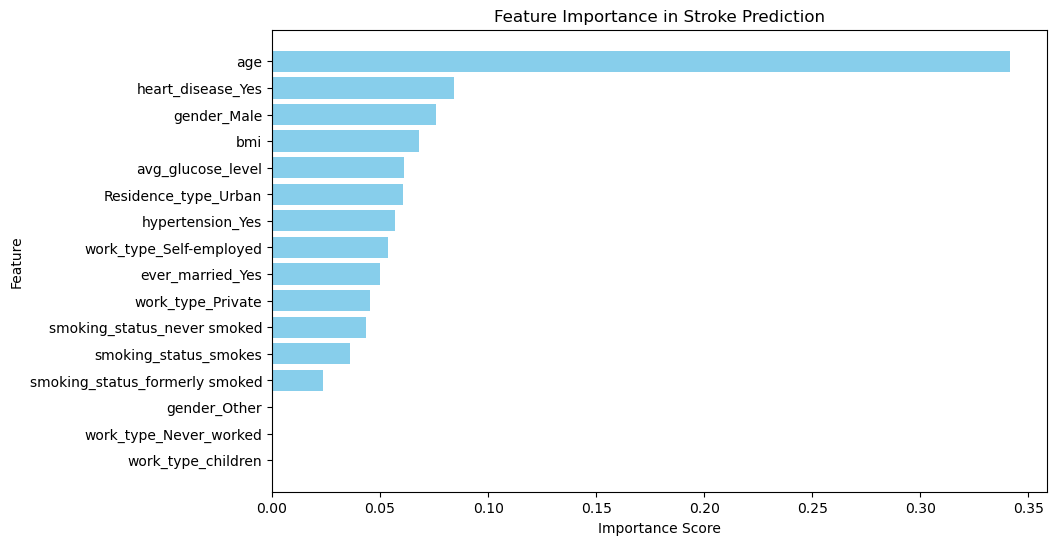

,Feature,Importance
0,age,0.341523
15,heart_disease_Yes,0.084231
3,gender_Male,0.075665
2,bmi,0.067790
1,avg_glucose_level,0.061088
10,Residence_type_Urban,0.060514
14,hypertension_Yes,0.056795
8,work_type_Self-employed,0.053540
5,ever_married_Yes,0.049775
7,work_type_Private,0.045505


In [7]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Stroke Prediction')
plt.gca().invert_yaxis()
plt.show()

importance_df


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


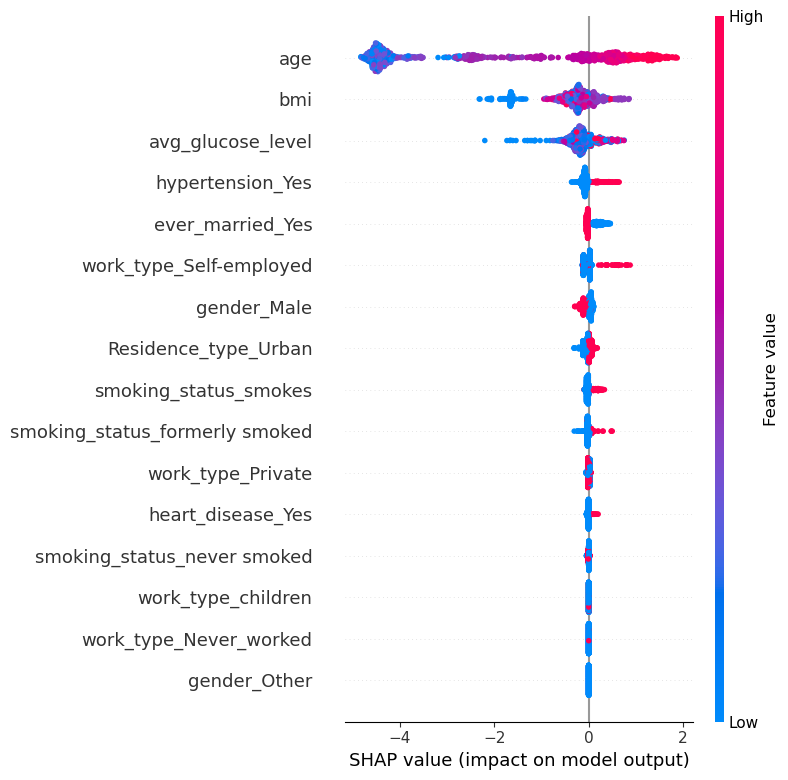

In [8]:
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


Recall

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [1, 10, 20, 50],
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='recall', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_}")


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 50}
Best Recall Score: 0.9549223579074325


In [10]:
from xgboost import XGBClassifier

model = XGBClassifier(scale_pos_weight=50, learning_rate=0.01, max_depth=3, n_estimators=50)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")

Accuracy: 0.4452054794520548
Precision for class 0: 99.51%
Recall for class 0: 41.87%
F1 Score for class 0: 58.94%
Precision for class 1: 7.83%
Recall for class 1: 96.00%
F1 Score for class 1: 14.48%


In [12]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Generate a detailed explanation of the confusion matrix
print(f"\nFor our {len(y_pred)} observations:\n")
print(f"{tn + fp} patients did not have a stroke")
print(f"  - {tn} patients who did not have a stroke were correctly classified as NOT having a stroke")
print(f"  - {fp} patients who did not have a stroke were INCORRECTLY classified as having a stroke\n")

print(f"{fn + tp} patients did have a stroke")
print(f"  - {tp} patients who had a stroke were correctly classified as having a stroke")
print(f"  - {fn} patients who had a stroke were INCORRECTLY classified as NOT having a stroke")



For our 1022 observations:

972 patients did not have a stroke
  - 407 patients who did not have a stroke were correctly classified as NOT having a stroke
  - 565 patients who did not have a stroke were INCORRECTLY classified as having a stroke

50 patients did have a stroke
  - 48 patients who had a stroke were correctly classified as having a stroke
  - 2 patients who had a stroke were INCORRECTLY classified as NOT having a stroke


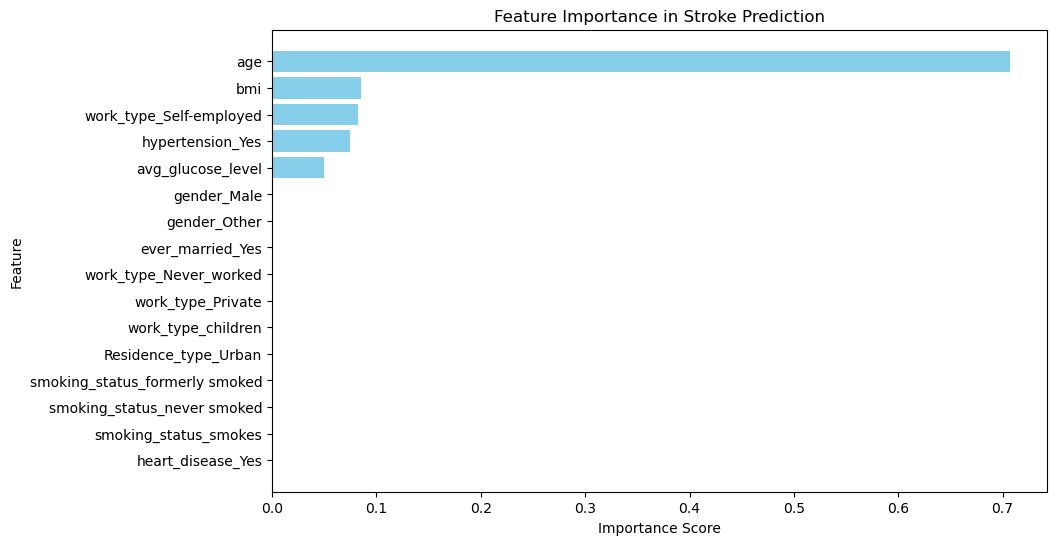

,Feature,Importance
0,age,0.707165
2,bmi,0.085441
8,work_type_Self-employed,0.082660
14,hypertension_Yes,0.074782
1,avg_glucose_level,0.049953
3,gender_Male,0.000000
4,gender_Other,0.000000
5,ever_married_Yes,0.000000
6,work_type_Never_worked,0.000000
7,work_type_Private,0.000000


In [13]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_

feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Stroke Prediction')
plt.gca().invert_yaxis()
plt.show()

importance_df


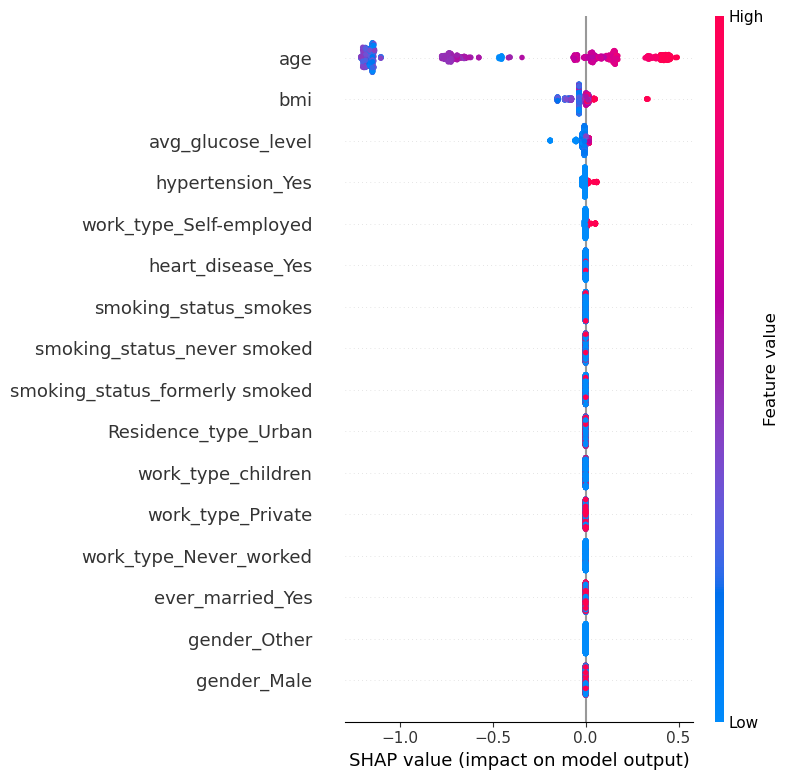

In [14]:
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


CV

In [15]:
# Cross Validation
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

# Perform cross-validation and get predictions for each fold
y_pred = cross_val_predict(model, X, y, cv=5)  # 5-fold cross-validation
y_test_cv = y  # In cross-validation, y_test is the true labels for all data

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test_cv, y_pred).ravel()

# Calculate accuracy
accuracy = accuracy_score(y_test_cv, y_pred)

# Calculate precision, recall, and F1 score for both classes
precision_0 = precision_score(y_test_cv, y_pred, pos_label=0)
recall_0 = recall_score(y_test_cv, y_pred, pos_label=0)
f1_0 = f1_score(y_test_cv, y_pred, pos_label=0)

precision_1 = precision_score(y_test_cv, y_pred, pos_label=1)
recall_1 = recall_score(y_test_cv, y_pred, pos_label=1)
f1_1 = f1_score(y_test_cv, y_pred, pos_label=1)

# Print class distribution
print(f"Predicted class distribution: {np.bincount(y_pred)}")
print(f"Actual class distribution: {np.bincount(y_test_cv)}")
print(f"Total observations: {len(y_pred)}")

# Print performance metrics
print(f"\nAccuracy: {accuracy * 100:.2f}%")

print(f"Precision for class 0: {precision_0 * 100:.2f}%")
print(f"Recall for class 0: {recall_0 * 100:.2f}%")
print(f"F1 Score for class 0: {f1_0 * 100:.2f}%")

print(f"Precision for class 1: {precision_1 * 100:.2f}%")
print(f"Recall for class 1: {recall_1 * 100:.2f}%")
print(f"F1 Score for class 1: {f1_1 * 100:.2f}%")

# Generate a detailed explanation of the confusion matrix
print(f"\nFor our {len(y_pred)} observations:\n")
print(f"{tn + fp} patients did not have a stroke")
print(f"  - {tn} patients who did not have a stroke were correctly classified as NOT having a stroke")
print(f"  - {fp} patients who did not have a stroke were INCORRECTLY classified as having a stroke\n")

print(f"{fn + tp} patients did have a stroke")
print(f"  - {tp} patients who had a stroke were correctly classified as having a stroke")
print(f"  - {fn} patients who had a stroke were INCORRECTLY classified as NOT having a stroke")


Predicted class distribution: [1935 3175]
Actual class distribution: [4861  249]
Total observations: 5110

Accuracy: 42.47%
Precision for class 0: 99.64%
Recall for class 0: 39.66%
F1 Score for class 0: 56.74%
Precision for class 1: 7.62%
Recall for class 1: 97.19%
F1 Score for class 1: 14.14%

For our 5110 observations:

4861 patients did not have a stroke
  - 1928 patients who did not have a stroke were correctly classified as NOT having a stroke
  - 2933 patients who did not have a stroke were INCORRECTLY classified as having a stroke

249 patients did have a stroke
  - 242 patients who had a stroke were correctly classified as having a stroke
  - 7 patients who had a stroke were INCORRECTLY classified as NOT having a stroke
